<a href="https://colab.research.google.com/github/FengboMa/1/blob/master/IE_7300_Lab_1_team_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gradient Descent for Linear Regression

##IE 7300 sec 1 Lab team 2

###Manvika Tuteja / Fengbo Ma

In   this   problem   you   will   be   working   with   three   datasets   for regression:

- Housing: This is a regression dataset where the task is to predict the value of houses in the suburbs of Boston based on thirteen features that describe different aspects that are relevant to determining the value of a house, such as the number of rooms, levels of pollution in the area, etc.

- Yacht:  This is a regression dataset where the task is to predict the resistance of a sailing yacht’s structure based on six different features that describe structural and buoyancy properties.

- Concrete: This is a regression dataset where the task is to predict   the   compressive   strength   of   concrete   on   eight different features. There are a total of 1030 instances and all the features are numeric.

Recall, the model for linear regression:


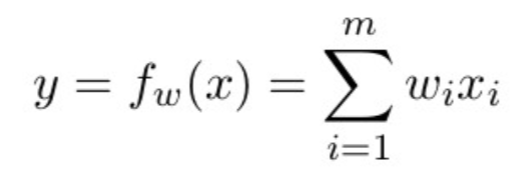

## Loading packages/libraries

In [ ]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sys import stderr
from tkinter import Y

## Set random seed

In [ ]:
np.random.seed(1)

In [ ]:
%matplotlib inline

# Linear Regression

## Build Linear Regression Class

In [ ]:
# Step 1 - Defining Classes 

class LinearRegression:
    def __init__(self, X, y, l2, batchSize, learningRate, epsilon, 
                 maxIteration, gd=False, sgd=False, regularization = False) -> None:
        self.X = X  
        self.y = y
        self.l2 = l2 # regularization parameter
        self.batchSize = batchSize # number of sample data points
        self.learningRate = learningRate
        self.epsilon = epsilon
        self.maxIteration = maxIteration
        self.gd = gd
        self.sgd = sgd
        self.regularization = regularization
        
# Step 2 - Splitting data into training and testing 

    def dataSplit(self):
        # split the data into train and test data
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,test_size=0.3, random_state=0)
        return X_train, X_test, y_train, y_test

# Step 3 - Adding a column with all ones and we're normalising the data 

    def add_X0(self, X):
        # add column vector of ones for b0
        return np.column_stack([np.ones(X.shape[0]), X])

    def normalizeData(self, X):
        # normalize the train data
        mean = np.mean(X, 0)
        std = np.std(X, 0)
        X_norm = (X - mean) / std
        X_norm = self.add_X0(X_norm) 
        return X_norm, mean, std
    
    def normalizeTestData(self, X, mean, std):
        X_norm = (X - mean) / std
        X_norm = self.add_X0(X_norm)
        return X_norm

# Step 4 - Closed form solution, checking the following: 

    # 1. full rank matrix - Rank = min(n,d) 
    # 2. low rank matrix n<d 

    def checkRank(self, X):
    #u, S, v = np.linalg.svd(X)
    #rank = len([i for i in S if 1>0])
      rank = np.linalg.matrix_rank(X)
      if rank == min(X.shape[0], X.shape[1]):
        self.fullRank = True
        print('Matrix is full rank')
      else: 
        self.fullRank = False
        print('Matrix is not full rank')
        
# Step 5 - Checking if number of columns < number of rows 

    def checkInvertibility(self,X):
        if X.shape[1] > X.shape[0]:
            print('Matrix is low rank')
            self.lowRank = True
        else:
            print('Matrix is not low rank')
            self.lowRank = False
            
# Step 6 - Closed form solution 

    def normalEquation(self, X,y):
        self.w = np.linalg.inv(X.T.dot(X)+(np.identity(X.shape[1])* self.l2)).dot(X.T.dot(y))
        print(self.w)
        return self.w
        
# Step 7 - Calculating the l2 T.dot(X)


    def predict(self, X):
        return X.dot(self.w)

# Step 8 - Gradient Descent 

    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y )**2).sum()
    
    def rmse(self, X, y):
        sse = self.sse(X, y)
        rms = np.sqrt(sse / len(y))
        return rms

# Step 9 - Cost Function

    def costFunction(self, X, y):
        if self.regularization == True:
          return (self.sse(X, y)+(self.l2*self.w.T.dot(self.w))) / 2
        else:
          return self.sse(X, y) / 2

# Step 10 - Cost Derivative

    def costDerivative(self,X ,y):
        if self.regularization == True:
          return X.T.dot(self.predict(X) - y) + self.l2 * self.w
        else:
          return X.T.dot(self.predict(X) - y)

# Step 11 - Gradient Descent Solution 

    def gradientDescent(self, X, y):
        errors = []
        lastError = float('inf')
        
        for i in tqdm(range(self.maxIteration)):
            self.w = self.w - self.learningRate * self.costDerivative(X,y)
            currentError = self.rmse(X,y)
            errors.append(currentError)
            difference = abs(lastError - currentError)
            lastError = currentError
            
            if np.abs(difference) < self.epsilon:
                print('Model stopped learning')
                break
        print(errors)
        self.plot_rmse(errors)

    def fit(self):
        X_train, X_test, y_train, y_test = self.dataSplit()
        X_train, mean, std = self.normalizeData(X_train)
        X_test = self.normalizeTestData(X_test, mean, std)

        self.checkRank(X_train)
        self.checkInvertibility(X_train)
        
        if self.fullRank and not self.lowRank and X_train.shape[0] <= 100000 and not self.gd and not self.sgd:
          print ('Using closed form solution')
          self.w = self.normalEquation(X_train, y_train)
        
        elif self.sgd:
          self.w = np.ones(X_train.shape[1], dtype = np.float64)
          print('Using stochastic gradient descent')
          self.w = self.stochasticGradientDescent(X_train, y_train)

        else:
          self.w = np.ones(X_train.shape[1], dtype=np.float64) * 0
          print('Using gradient descent')
          self.w = self.gradientDescent(X_train, y_train)

# Step 12 - Stochastic Gradient Descent 


    def stochasticGradientDescent(self, X, y):

        errors = []
        lastError = float('inf')

        for i in tqdm(range(self.maxIteration)):
            randnum = np.random.randint(0, X.shape[0], size = 50)
            self.w = self.w - self.learningRate * self.costDerivative(X[randnum,], y[randnum,])
            currentError = self.rmse(X, y)
            difference = lastError - currentError
            errors.append(currentError)
            lastError = currentError

            if np.abs(difference) < self.epsilon:
               print('Model stopped learning')
               break
        print(errors)
        self.plot_rmse(errors)


    def plot_rmse(self, errors):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(errors)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel='errors')
        ax.grid()

        ax.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()    

## Import Dataset

In [ ]:
df1 = pd.read_csv("concreteData.csv")
df2 = pd.read_csv("housing.csv")
df3 = pd.read_csv("yachtData.csv")

#Result

##Gradient Descent without regularization

1. Concrete Data

In [ ]:
regression1 =  LinearRegression(df1.values[:, 0:-1], df1.values[:, -1], l2 = 0, 
                          batchSize = 0, learningRate = 0.7e-3, epsilon = 0.1e-2, 
                          maxIteration = 50000, gd = True, sgd = False, regularization = False)

Matrix is full rank
Matrix is not low rank
Using gradient descent


  0%|          | 67/50000 [00:00<00:06, 7795.67it/s]


Model stopped learning
[21.305202218438826, 13.976361274688044, 11.459737723764283, 10.7098977279699, 10.484570712397478, 10.40239392316292, 10.360601556031428, 10.332128403074314, 10.309536173896275, 10.290495775027791, 10.274064189484518, 10.259717363505155, 10.24708948727537, 10.235896172560768, 10.225907121471344, 10.216933125346484, 10.208817911638848, 10.201432121595472, 10.194668535659419, 10.188438186957928, 10.182667168371585, 10.177294001409722, 10.172267466178953, 10.167544811458312, 10.163090278504779, 10.158873883831458, 10.154870415701192, 10.151058606924463, 10.14742045304817, 10.1439406504052, 10.140606132951584, 10.13740569050537, 10.134329654049274, 10.131369636277004, 10.128518317641545, 10.12576926987868, 10.123116810393421, 10.120555882063055, 10.118081953971572, 10.115690939382175, 10.113379127906892, 10.111143129369644, 10.108979827301637, 10.106886340372323, 10.104859990359161, 10.102898275506364, 10.100998848326237, 10.099159497063926, 10.097378130184302, 10.09

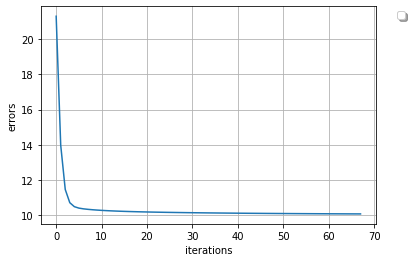

In [ ]:
regression1.fit()

2. Housing

In [ ]:
regression2 = LinearRegression(df2.values[:, 0:-1], df2.values[:, -1], l2 = 0, batchSize = 0, 
                              learningRate = 0.4e-3, epsilon = 0.5e-2,
                              maxIteration = 50000, gd = True, sgd=False, regularization = False)

Matrix is full rank
Matrix is not low rank
Using gradient descent


  0%|          | 30/50000 [00:00<00:03, 16416.06it/s]


Model stopped learning
[20.83715993891805, 18.019835851845546, 15.653922302725285, 13.660572870410373, 11.987561072779394, 10.590744902870359, 9.432098351606836, 8.478465332382818, 7.700556074104222, 7.072194327004184, 6.569829308061421, 6.172292737229014, 5.8607363089218705, 5.618653820102924, 5.43189346887406, 5.288597741783017, 5.179051934547725, 5.095457373462891, 5.0316622468371355, 4.982883567146062, 4.945445430655285, 4.916548173427822, 4.894074114890963, 4.8764295913420295, 4.862419686233529, 4.851150708906085, 4.841955302123089, 4.834335501709882, 4.82791976341351, 4.822430706061919, 4.817660994306494]


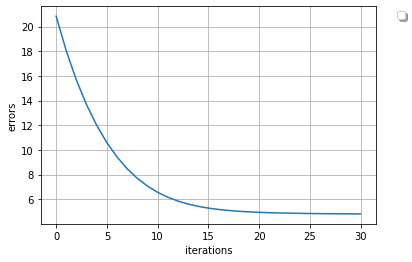

In [ ]:
regression2.fit()

3. Yacht Data

In [ ]:
regression3 = LinearRegression(df3.values[:, 0:-1], df3.values[:, -1], l2 = 0, batchSize = 0, 
                              learningRate = 0.1e-2, epsilon = 0.1e-2,
                              maxIteration = 50000, gd = True, sgd=False, regularization = False)

Matrix is full rank
Matrix is not low rank
Using gradient descent


  0%|          | 19/50000 [00:00<00:02, 18261.18it/s]


Model stopped learning
[15.890642134337385, 13.628194656316035, 12.021512147560633, 10.912424685897104, 10.167537185649996, 9.679034712577911, 9.36464867120833, 9.16508862009007, 9.039614957282042, 8.96121776399533, 8.912431207247169, 8.882147444133642, 8.863377710227608, 8.851754668153147, 8.844560663992294, 8.840108974197628, 8.837354363090013, 8.835649709641793, 8.834594578464232, 8.83394124810321]


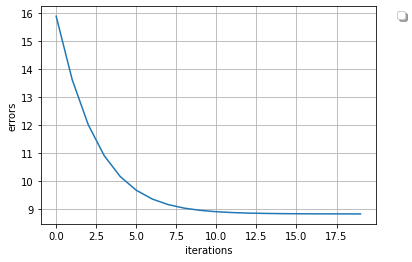

In [ ]:
regression3.fit()

##Gradient Descent with regularization

Setting Regularization parameter to 20

1. Concrete Data

In [ ]:
regression1N =  LinearRegression(df1.values[:, 0:-1], df1.values[:, -1], l2 = 20, 
                          batchSize = 0, learningRate = 0.7e-3, epsilon = 0.1e-2, 
                          maxIteration = 50000, gd = True, sgd = False, regularization = True)

Matrix is full rank
Matrix is not low rank
Using gradient descent


  0%|          | 53/50000 [00:00<00:09, 5147.34it/s]


Model stopped learning
[21.305202218438826, 14.151381080321348, 11.676957275498715, 10.885103783913008, 10.612584232364352, 10.499399853697398, 10.440719002442691, 10.40406982144254, 10.378031644901295, 10.357940074303178, 10.341604165943867, 10.327865699623523, 10.316048306352338, 10.305721690881843, 10.296591515735418, 10.288444358883462, 10.281118499896166, 10.274487446918696, 10.268450034590147, 10.262924073460857, 10.257842024378046, 10.253147898604016, 10.248794947216544, 10.244743888982466, 10.240961523953406, 10.237419633981217, 10.234094102562377, 10.230964205542934, 10.228012036644108, 10.225222040299345, 10.222580630422312, 10.220075878284993, 10.217697256163909, 10.215435426113142, 10.213282065343853, 10.211229721368728, 10.209271691405423, 10.207401921599285, 10.205614922479288, 10.203905697745421, 10.20226968403555, 10.200702699761852, 10.199200901462955, 10.197760746404889, 10.19637896039572, 10.195052509966088, 10.193778578219462, 10.192554543778938, 10.191377962357343,

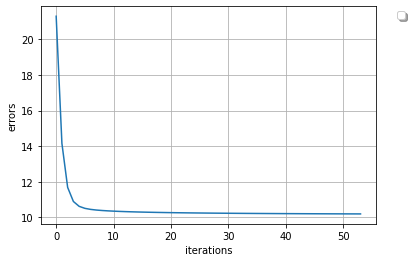

In [ ]:
regression1N.fit()

2. Housing

In [ ]:
regression2N = LinearRegression(df2.values[:, 0:-1], df2.values[:, -1], l2 = 20, batchSize = 0, 
                              learningRate = 0.4e-3, epsilon = 0.5e-2,
                              maxIteration = 50000, gd = True, sgd=False, regularization = True)

Matrix is full rank
Matrix is not low rank
Using gradient descent


  0%|          | 36/50000 [00:00<00:02, 18602.31it/s]


Model stopped learning
[20.83715993891805, 18.046176649402362, 15.723355236034958, 13.783510991096536, 12.168597652487687, 10.829774152879247, 9.725239536624269, 8.81891648170228, 8.079463354497944, 7.479558120386359, 6.995405465697261, 6.606402981506729, 6.294894947425353, 6.045951357313581, 5.847132299304635, 5.68822385565774, 5.5609519058811046, 5.458690350461213, 5.376181388412347, 5.309281268180764, 5.254739026924516, 5.210010451123508, 5.17310576958731, 5.142467470310161, 5.116873758664887, 5.095363112134942, 5.077175773000883, 5.061708602066421, 5.048480339271249, 5.0371048985125775, 5.027270828056625, 5.0187254852377015, 5.011262809261834, 5.004713839439026, 4.998939330318966, 4.993823971720424, 4.989271840762419]


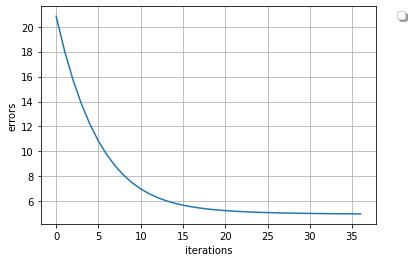

In [ ]:
regression2N.fit()

3. Yacht Data

In [ ]:
regression3N = LinearRegression(df3.values[:, 0:-1], df3.values[:, -1], l2 = 20, batchSize = 0, 
                              learningRate = 0.1e-2, epsilon = 0.1e-2,
                              maxIteration = 50000, gd = True, sgd=False, regularization = True)

Matrix is full rank
Matrix is not low rank
Using gradient descent


  0%|          | 24/50000 [00:00<00:02, 17400.74it/s]


Model stopped learning
[15.890642134337385, 13.6831670623251, 12.146963258106226, 11.099597920383184, 10.396803391960995, 9.92960816023693, 9.619752801567133, 9.413444095237397, 9.274874940565969, 9.180681721217589, 9.11576424093055, 9.07037526562905, 9.03819144910726, 9.01507121600614, 8.998267158584246, 8.985929626021534, 8.976793640329364, 8.969980319927727, 8.964869733211689, 8.961018470857919, 8.958105423392242, 8.955895537442133, 8.95421518298751, 8.95293513269231, 8.951958613676883]


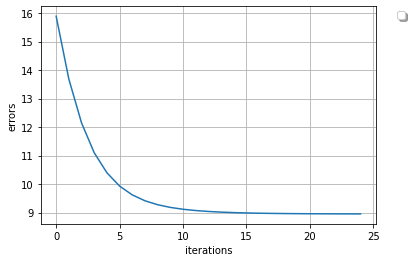

In [ ]:
regression3N.fit()

## Stochastic Gradient Descent without regularization

1. Concrete Data

In [ ]:
regression1sgd =  LinearRegression(df1.values[:, 0:-1], df1.values[:, -1], l2 = 0, 
                          batchSize = 0, learningRate = 0.7e-3, epsilon = 0.1e-2, 
                          maxIteration = 50000, gd = False, sgd=True, regularization = False)

Matrix is full rank
Matrix is not low rank
Using stochastic gradient descent


  0%|          | 79/50000 [00:00<00:10, 4745.57it/s]


Model stopped learning
[37.107472530687254, 35.89919926675775, 35.034087483599805, 33.78099188723759, 32.723739084662164, 31.566963626576104, 30.52781474908821, 29.27333835584144, 28.439975306859896, 27.58662929287893, 26.68691106348122, 25.96040471327936, 25.381821508633166, 24.7583131601793, 24.14406037422736, 23.546668659463847, 22.93299933802318, 22.497872992136305, 21.852604186476224, 21.32021581784412, 20.595226605902162, 20.124454117223294, 19.66377625624012, 19.22353649880448, 18.560366784195452, 18.130879676043385, 17.80226744504414, 17.33623747872294, 16.954586023531753, 16.535088393420963, 16.146807147452765, 15.888377413162052, 15.557539260161251, 15.227269875103097, 14.933586904932062, 14.638555216107111, 14.396193584726847, 14.099572601121022, 13.903369161795268, 13.627625433807175, 13.415839130433312, 13.242453970720357, 13.135402199284515, 12.981607949480463, 12.816224400857632, 12.607443531654416, 12.530255874467022, 12.364433116517995, 12.328259853834245, 12.199231669

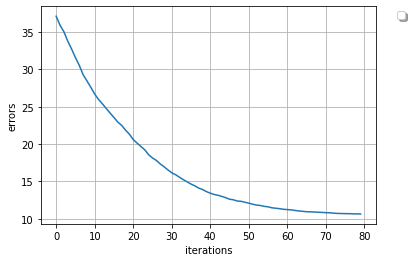

In [ ]:
regression1sgd.fit()

2. Housing

In [ ]:
regression2sgd = LinearRegression(df2.values[:, 0:-1], df2.values[:, -1], l2 = 0, batchSize = 0, 
                              learningRate = 0.4e-3, epsilon = 0.5e-2,
                              maxIteration = 50000, gd = False, sgd=True, regularization = False)

Matrix is full rank
Matrix is not low rank
Using stochastic gradient descent


  0%|          | 132/50000 [00:00<00:05, 8576.78it/s]


Model stopped learning
[24.08780461439648, 23.329546178580326, 22.79047053375162, 22.36002366594823, 21.836887757339532, 21.398090240649513, 20.887488484183468, 20.42596408858065, 19.97634439655603, 19.57866524657901, 19.065332042702547, 18.74989758816628, 18.363201046590145, 18.00147024619971, 17.655309946614384, 17.42961369345847, 17.084228091239847, 16.735756170229696, 16.451969904990182, 16.177919207999476, 15.880043264331901, 15.597991725230914, 15.321912725810499, 15.076759534294162, 14.817555021170495, 14.540903280664319, 14.299408906647804, 14.036366968134898, 13.77117721811801, 13.575185643791219, 13.365326244950232, 13.091212889236278, 12.865913150161928, 12.672891225031323, 12.445753399490705, 12.272048928373145, 12.101617151475205, 11.925495049541157, 11.731771100730077, 11.543126233230188, 11.28746028174448, 11.118804071267794, 10.910798179011493, 10.779538167657345, 10.629233473139893, 10.430000288957554, 10.254805795766137, 10.060375426799947, 9.906379143662775, 9.761151

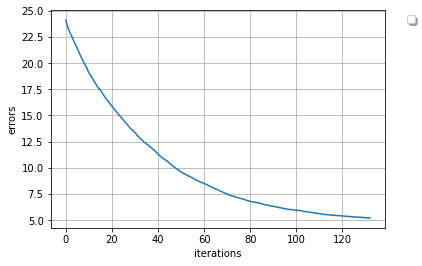

In [ ]:
regression2sgd.fit()

3. Yacht Data

In [ ]:
regression3sgd = LinearRegression(df3.values[:, 0:-1], df3.values[:, -1], l2 = 0, batchSize = 0, 
                              learningRate = 0.1e-2, epsilon = 0.1e-2,
                              maxIteration = 50000, gd = False, sgd=True, regularization = False)

Matrix is full rank
Matrix is not low rank
Using stochastic gradient descent


  0%|          | 53/50000 [00:00<00:08, 5930.64it/s]


Model stopped learning
[17.18767878462324, 16.70187115857504, 16.15234304931492, 15.450265483588895, 14.943309373793873, 14.753279085695082, 14.246952675820713, 14.006422560233034, 13.59422579534997, 13.15326389407437, 12.870768007525953, 12.647333413233534, 12.269960128290117, 12.087818210137577, 11.654261974884662, 11.384323325636203, 11.172129022575106, 10.830629271676221, 10.664964475353052, 10.4442021587856, 10.184249654510113, 10.063798439886394, 9.91163556989312, 9.821832678415053, 9.737505548143938, 9.64572649434454, 9.648863749327226, 9.521602814289423, 9.503452219322503, 9.40488705414936, 9.399100180392548, 9.322249128577948, 9.297806145358148, 9.24506389949401, 9.198943895971142, 9.146608381211504, 9.1278689191979, 9.053643019932972, 9.027982019109322, 9.008326736208245, 9.018187008676232, 9.036806906919294, 8.99676637779252, 8.9632204615446, 8.966489301777482, 8.95052628033979, 8.944141402116863, 8.926109706592998, 8.920469064781035, 8.924161902587292, 8.91779979704668, 8.9

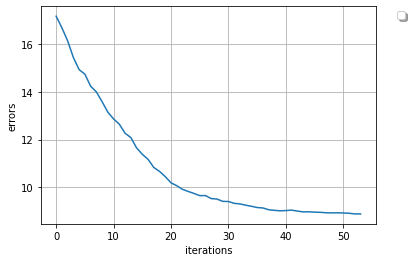

In [ ]:
regression3sgd.fit()

## Stochastic Gradient Descent with regularization
Setting Regularization parameter to 20

1. Concrete Data

In [ ]:
regression1sgdN =  LinearRegression(df1.values[:, 0:-1], df1.values[:, -1], l2 = 20, 
                          batchSize = 0, learningRate = 0.7e-3, epsilon = 0.1e-2, 
                          maxIteration = 50000, gd = False, sgd = True, regularization = True)

Matrix is full rank
Matrix is not low rank
Using stochastic gradient descent


  1%|          | 299/50000 [00:00<00:05, 8634.30it/s]


Model stopped learning
[36.824861674560246, 35.715758092357284, 34.52642700152376, 33.41551037543879, 32.519597200720064, 31.621349166664405, 30.75439634530459, 29.930033121701094, 29.089255170828803, 28.30895525543191, 27.578666914360745, 26.8444578267809, 26.016493793150953, 25.45852537543977, 24.8907525742407, 24.485858187715174, 23.958065725985836, 23.52160554405457, 23.098121371820273, 22.685279545625356, 22.303663683541117, 21.949614574717675, 21.547412336932016, 21.317114508506112, 20.942864298757456, 20.660421014491487, 20.43569745601336, 20.131252255878845, 19.878098621610263, 19.568333433531034, 19.332315328385, 19.159757623802264, 19.08375105590116, 18.834661854534442, 18.68884340854526, 18.461541591362536, 18.35015126002198, 18.20863207699404, 18.107518812204418, 17.888071445524787, 17.86085201815138, 17.84827867340394, 17.68527528018065, 17.511616492771203, 17.411463514662035, 17.305988241381474, 17.162463372130787, 17.144511595756274, 17.025777416125464, 16.93454684720653

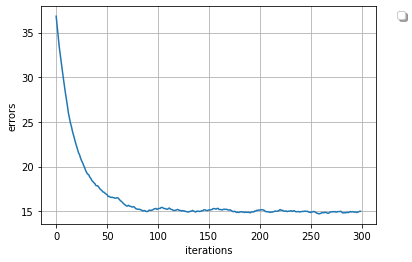

In [ ]:
regression1sgdN.fit()

2. Housing

In [ ]:
regression2sgdN = LinearRegression(df2.values[:, 0:-1], df2.values[:, -1], l2 = 20, batchSize = 0, 
                              learningRate = 0.4e-3, epsilon = 0.5e-2,
                              maxIteration = 50000, gd = False, sgd=True, regularization = True)

Matrix is full rank
Matrix is not low rank
Using stochastic gradient descent


  0%|          | 104/50000 [00:00<00:09, 5308.02it/s]


Model stopped learning
[24.155790086938612, 23.4235599866905, 22.795502227836543, 22.382856013571043, 21.99016118994866, 21.589152617495255, 21.19495531651017, 20.661058835938054, 20.180493205403092, 19.783344832751038, 19.277172613080236, 19.06227146269819, 18.740564224237627, 18.401029572105475, 18.039913764356516, 17.707047338348143, 17.47630303260867, 17.206231462368127, 16.99677583263393, 16.783924915535305, 16.545562233491, 16.306473574492358, 16.07908428134975, 15.889137557187926, 15.711331620822753, 15.40625922353364, 15.160168659686033, 14.948761154684163, 14.719025441810066, 14.529720999394268, 14.360499005239651, 14.21159262167263, 14.035293353391388, 13.84034012971789, 13.71058730410418, 13.573308114252136, 13.389676431493855, 13.244314295956853, 13.080611103668607, 12.936890846983973, 12.821585243908366, 12.703237123933583, 12.527571206382488, 12.370632688141924, 12.222077656565078, 12.1204531756487, 12.031008190394363, 11.963153559314364, 11.887864453219716, 11.7877247657

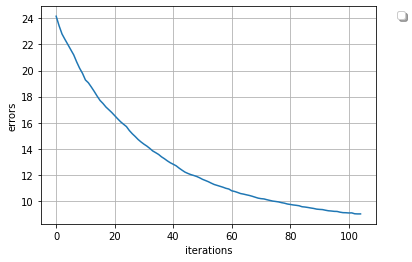

In [ ]:
regression2sgdN.fit()

3. Yacht Data

In [ ]:
regression3sgdN = LinearRegression(df3.values[:, 0:-1], df3.values[:, -1], l2 = 20, batchSize = 0, 
                              learningRate = 0.1e-2, epsilon = 0.1e-2,
                              maxIteration = 50000, gd = False, sgd=True, regularization = True)

Matrix is full rank
Matrix is not low rank
Using stochastic gradient descent


  0%|          | 149/50000 [00:00<00:05, 9770.97it/s]


Model stopped learning
[17.123753879153238, 16.421784755546245, 15.941982423260304, 15.325323003745, 14.918893028329936, 14.494401066610944, 14.208181474809152, 13.909926646532842, 13.752114318712527, 13.534590316017988, 13.273660136096966, 12.948152761737338, 12.659826085626642, 12.380321646640827, 12.084303859581029, 11.929056750884557, 11.670384050673574, 11.584738396949634, 11.634526178655578, 11.461141086811253, 11.353723050388513, 11.269275444778328, 11.093902997167545, 10.97891686407319, 11.020307273770612, 10.944876284013674, 10.997681982283469, 10.79061311318685, 10.635972365270826, 10.472869061752133, 10.354596207937966, 10.285851386253512, 10.295611324396745, 10.258899237795449, 10.160226633726683, 10.213225065304325, 10.12374956928237, 10.083698367222174, 10.124653421277854, 10.182633375358973, 10.15677373260364, 10.029040731766049, 10.009357555651537, 10.031032753751688, 9.998225273840896, 9.995113893391906, 10.022065901519584, 9.895729395555762, 9.907268604972577, 9.96114

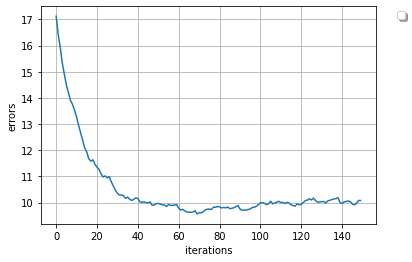

In [ ]:
regression3sgdN.fit()

## Close Form Solution without regularization

1. Concrete Data

In [ ]:
regression1cfs =  LinearRegression(df1.values[:, 0:-1], df1.values[:, -1], l2 = 0, 
                          batchSize = 0, learningRate = 0.7e-3, epsilon = 0.1e-2, 
                          maxIteration = 50000, gd = False, sgd = False, regularization = False)

In [ ]:
regression1cfs.fit()

Matrix is full rank
Matrix is not low rank
Using closed form solution
[35.55869444 13.07061719  9.29612788  6.07754028 -2.38797659  2.13444427
  1.74782814  1.75752107  7.36636378]


2. Housing

In [ ]:
regression2cfs = LinearRegression(df2.values[:, 0:-1], df2.values[:, -1], l2 = 0, batchSize = 0, 
                              learningRate = 0.4e-3, epsilon = 0.5e-2,
                              maxIteration = 50000, gd = False, sgd=False, regularization = False)

In [ ]:
regression2cfs.fit()

Matrix is full rank
Matrix is not low rank
Using closed form solution
[22.93399433 -0.90751811  1.04796575  0.38867104  0.6622465  -2.17214484
  2.58716716  0.50645061 -2.59559964  2.30818886 -1.67320027 -2.33651383
  0.65618617 -3.99472177]


3. Yacht Data

In [ ]:
regression3cfs = LinearRegression(df3.values[:, 0:-1], df3.values[:, -1], l2 = 0, batchSize = 0, 
                              learningRate = 0.1e-2, epsilon = 0.1e-2,
                              maxIteration = 50000, gd = False, sgd=False, regularization = False)

In [ ]:
regression3cfs.fit()

Matrix is full rank
Matrix is not low rank
Using closed form solution
[10.74271028  0.54271589 -0.48644592  0.53145418 -0.58852203 -0.84401335
 12.89451446]


## Close Form Solution with regularization
Setting Regularization parameter to 20

1. Concrete Data

In [ ]:
regression1cfsN =  LinearRegression(df1.values[:, 0:-1], df1.values[:, -1], l2 = 20, 
                          batchSize = 0, learningRate = 0.7e-3, epsilon = 0.1e-2, 
                          maxIteration = 50000, gd = False, sgd = False, regularization = True)

In [ ]:
regression1cfsN.fit()

Matrix is full rank
Matrix is not low rank
Using closed form solution
[34.59764865 10.04730138  6.28242128  3.39312583 -4.13028748  2.28685269
 -0.15522455 -0.75398562  7.02438216]


2. Housing

In [ ]:
regression2cfsN = LinearRegression(df2.values[:, 0:-1], df2.values[:, -1], l2 = 20, batchSize = 0, 
                              learningRate = 0.4e-3, epsilon = 0.5e-2,
                              maxIteration = 50000, gd = False, sgd=False, regularization = True)

In [ ]:
regression2cfsN.fit()

Matrix is full rank
Matrix is not low rank
Using closed form solution
[21.70428954 -0.78856391  0.81641919  0.02464325  0.71489715 -1.55916395
  2.73550498  0.24378172 -2.14353995  1.30317129 -0.87421694 -2.15523697
  0.64044827 -3.62666843]


3. Yacht Data

In [ ]:
regression3cfsN = LinearRegression(df3.values[:, 0:-1], df3.values[:, -1], l2 = 20, batchSize = 0, 
                              learningRate = 0.1e-2, epsilon = 0.1e-2,
                              maxIteration = 50000, gd = False, sgd=False, regularization = False)

In [ ]:
regression3cfsN.fit()

Matrix is full rank
Matrix is not low rank
Using closed form solution
[ 9.82452991  0.5195912  -0.58299843 -0.0943319  -0.07619538 -0.2292927
 11.78927367]


#Observiation 

1. **Normalization** the best way to prevent overfitting and reduce high variance issue in linear regression. The normalization parameter as a super-parameter should be finely tuned. In this lab, we tuned the parameter manully and desided with 20 for all. We under stand by using given parameters, the alpha-learning rate is bigger than neccsary, we have to introduce a huge norm parameter to make the variable visable on the plot.
 

2. It is really depent on how to code the **Stochastic Gradient Decent**. We would like to think about the idea similar to the NN tuning techunique, random drop out. It abenden some input to prevent overfitting. We are curious that when we trying to calculate the error. Do we obtain the error based on all the data points or on the sampled data points. Normally, we are expecting heavy noises when doing SGD.


3. We found out that for all three dataset we are having here today, all the data sets are Full Rank and invertable. It make sense since most of the data sets are long matrix. We are expecting that they are full rank and invertable. With the data set size we are working with right now, **Close form solution** might always be a reasonable choice. 
